# 🏘 House Price Prediction (Ames Housing Dataset)

**Goal:** The goal is simple: build a predictive model that accurately estimates home sale prices in Ames, Iowa by uncovering hidden patterns in the dataset. You'll need to analyze all 79 features—from obvious factors like square footage to subtle influences like neighborhood zoning—and engineer the best approach to beat the competition. The most accurate predictions win.

**Dataset:** Ames Housing dataset (`train.csv`). Contains 79 explanatory features describing residential homes and the target variable `Sale Price`.


We will be working with [kaggle](https://kaggle.com) platform during our [competition](https://www.kaggle.com/competitions/house-prices-iaac/overview). Go through these tabs to read more about the data, the rules and the other teams. 

<img src="../.assets/kaggle/hello_kaggle.jpg" width=50%>

### ⚙️ Setup

In [12]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set plotting style
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (12, 7)

# Function for Root Mean Squared Log Error (RMSLE)
def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_error(np.log1p(y_true), np.log1p(y_pred)))

# Function for Cross-Validation scoring (using RMSLE)
def cv_rmsle(model, X, y):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    # Note: We use log1p transform on y for scoring, as models predict log(price)
    # Need to inverse transform y_pred if model predicts log price
    # Simpler approach: predict original scale and calc RMSLE, or predict log scale and calc RMSE on log scale
    # We'll train models to predict log(price) and calculate RMSE on that log scale.
    rmse_scores = np.sqrt(-cross_val_score(model, X, np.log1p(y), 
                                            scoring="neg_mean_squared_error", 
                                            cv=kf))
    return rmse_scores

## 🔎 Load and Explore Data (EDA)

<img src="../.assets/kaggle/get_data.jpg" width=50%>

In [13]:
df_train = pd.read_csv('/home/salvador_cb/3_term/AECinCode_tutorials/house-prices-iaac/train.csv')

# Keep the Id column for potential future reference but drop for modeling
train_ids = df_train['Id']
df_train.drop('Id', axis=1, inplace=True)

print(f"\nTraining data shape: {df_train.shape}")

# Display basic information
print("\n--- Dataset Info ---")
# df_train.info() # Can be very long, maybe just show head and describe

print("\n--- First 5 Rows ---")
print(df_train.head())

print("\n--- Descriptive Statistics (Numerical Features) ---")
print(df_train.describe())


Training data shape: (1758, 82)

--- Dataset Info ---

--- First 5 Rows ---
   Order        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street  \
0   1323  902405070           70        RM          60.0     10800   Pave   
1   2476  531376030           60        RL          65.0      7800   Pave   
2   2091  906201022           20        RL         114.0     10357   Pave   
3   2734  905403050           50        RL          62.0      6488   Pave   
4   2882  911175440          190   C (all)          50.0      9000   Pave   

  Alley Lot Shape Land Contour  ... Pool Area Pool QC Fence Misc Feature  \
0   NaN       Reg          Lvl  ...         0     NaN   NaN          NaN   
1   NaN       Reg          Lvl  ...         0     NaN   NaN          NaN   
2   NaN       IR1          Lvl  ...         0     NaN   NaN          NaN   
3   NaN       Reg          Lvl  ...         0     NaN   NaN          NaN   
4   NaN       Reg          Lvl  ...         0     NaN   NaN          NaN   

  M

## EDA

Explore the data and work with missing variables. 

### Missing Value Analysis

The amount of missing values and the semantics of the features are an indicator of which _strategy_ we want to use when working with the missing values.

* remove the feature?
* remove certain rows? (probably not here, as the dataset is rather small)
* replace them with
    * 0 (or any other numerical placeholder)
    * average value
* interpolate or deduce?
* fill in manually?


Skewness of SalePrice: 1.76


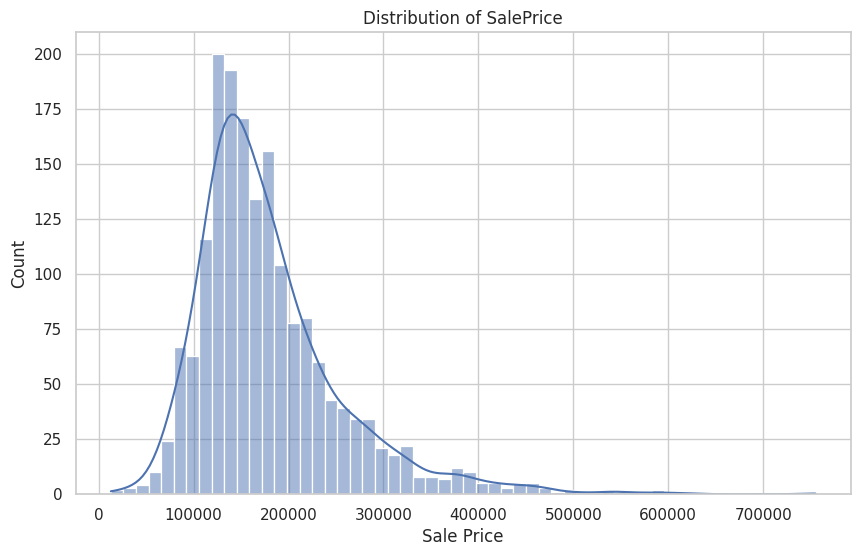

Skewness of Log-Transformed SalePrice: -0.11


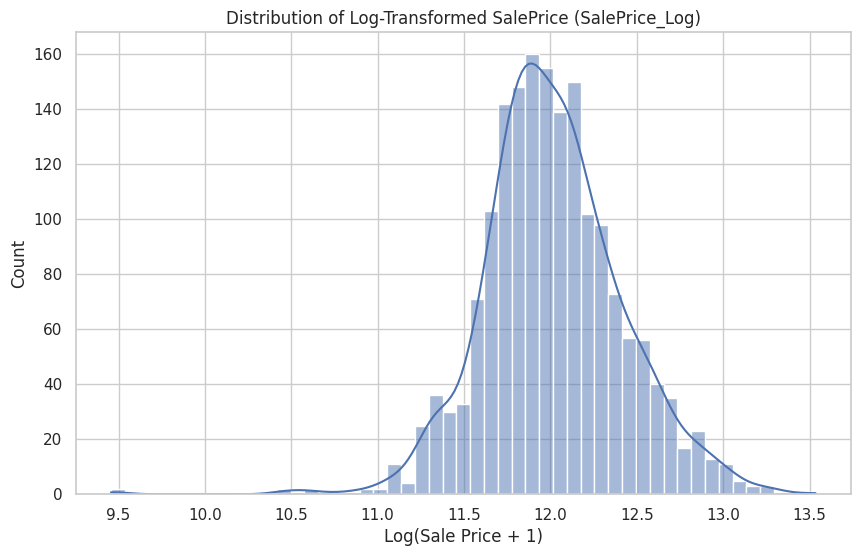

In [14]:
plt.figure(figsize=(10, 6))
sns.histplot(df_train['SalePrice'], kde=True)
plt.title('Distribution of SalePrice')
plt.xlabel('Sale Price')
print(f"\nSkewness of SalePrice: {df_train['SalePrice'].skew():.2f}") # Check skewness
plt.show()

# Apply log transformation to SalePrice to reduce skewness (common practice)
df_train['SalePrice_Log'] = np.log1p(df_train['SalePrice']) # log1p handles potential 0 values safely

plt.figure(figsize=(10, 6))
sns.histplot(df_train['SalePrice_Log'], kde=True)
plt.title('Distribution of Log-Transformed SalePrice (SalePrice_Log)')
plt.xlabel('Log(Sale Price + 1)')
print(f"Skewness of Log-Transformed SalePrice: {df_train['SalePrice_Log'].skew():.2f}") # Check skewness after transform
plt.show()


--- Features with Missing Values ---
                Missing Count  Percentage (%)
Pool QC                  1752       99.658703
Misc Feature             1692       96.245734
Alley                    1636       93.060296
Fence                    1411       80.261661
Mas Vnr Type             1055       60.011377
Fireplace Qu              877       49.886234
Lot Frontage              308       17.519909
Garage Qual                99        5.631399
Garage Cond                99        5.631399
Garage Finish              99        5.631399
Garage Yr Blt              99        5.631399
Garage Type                98        5.574516
Bsmt Exposure              44        2.502844
BsmtFin Type 1             42        2.389078
Bsmt Cond                  42        2.389078
BsmtFin Type 2             42        2.389078
Bsmt Qual                  42        2.389078
Mas Vnr Area               12        0.682594
Bsmt Unf SF                 1        0.056883
BsmtFin SF 2                1        0.056

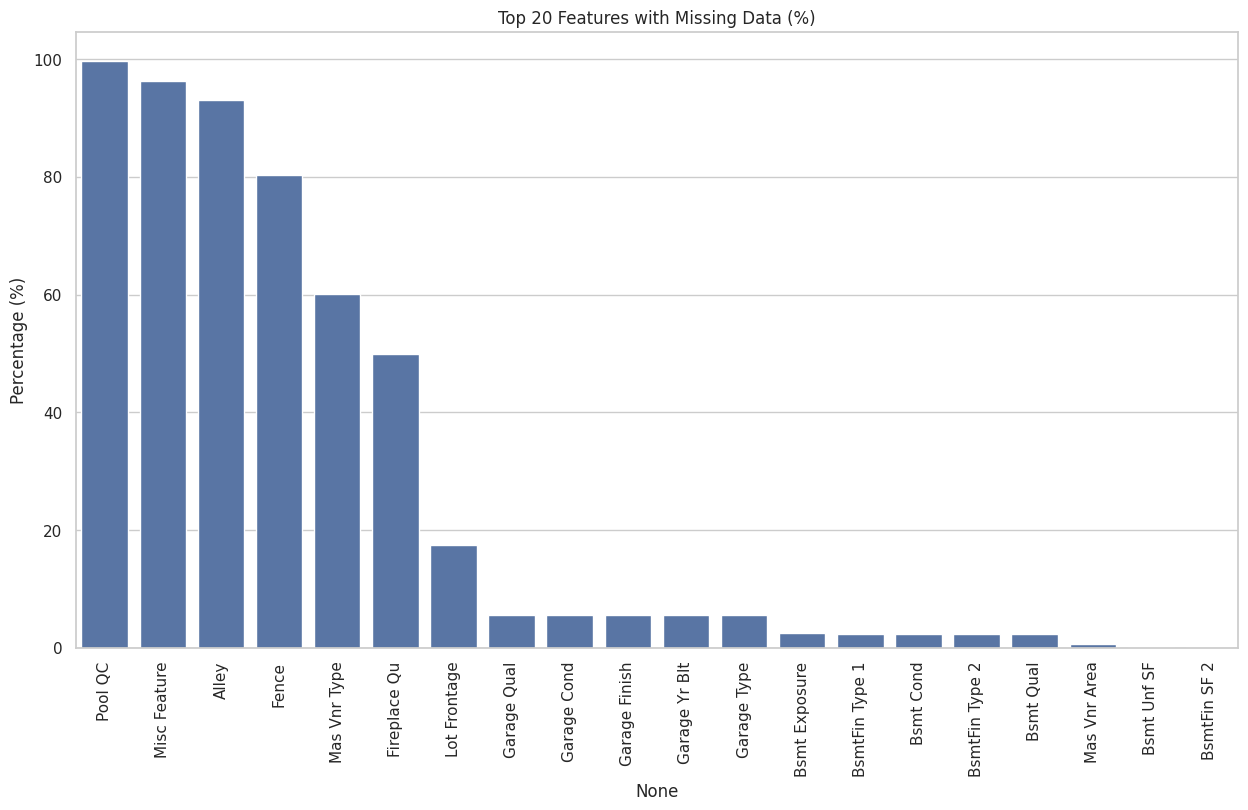

In [15]:
# Check for missing values
missing = df_train.isnull().sum().sort_values(ascending=False)
missing = missing[missing > 0] # Filter only columns with missing values
missing_perc = (missing / len(df_train)) * 100

missing_data = pd.DataFrame({'Missing Count': missing, 'Percentage (%)': missing_perc})
print("\n--- Features with Missing Values ---")
print(missing_data.head(20)) # Show top 20 features with missing values

plt.figure(figsize=(15, 8))
sns.barplot(x=missing_data.index[:20], y=missing_data['Percentage (%)'][:20])
plt.title('Top 20 Features with Missing Data (%)')
plt.xticks(rotation=90)
plt.ylabel('Percentage (%)')
plt.show()


### Feature Correlations

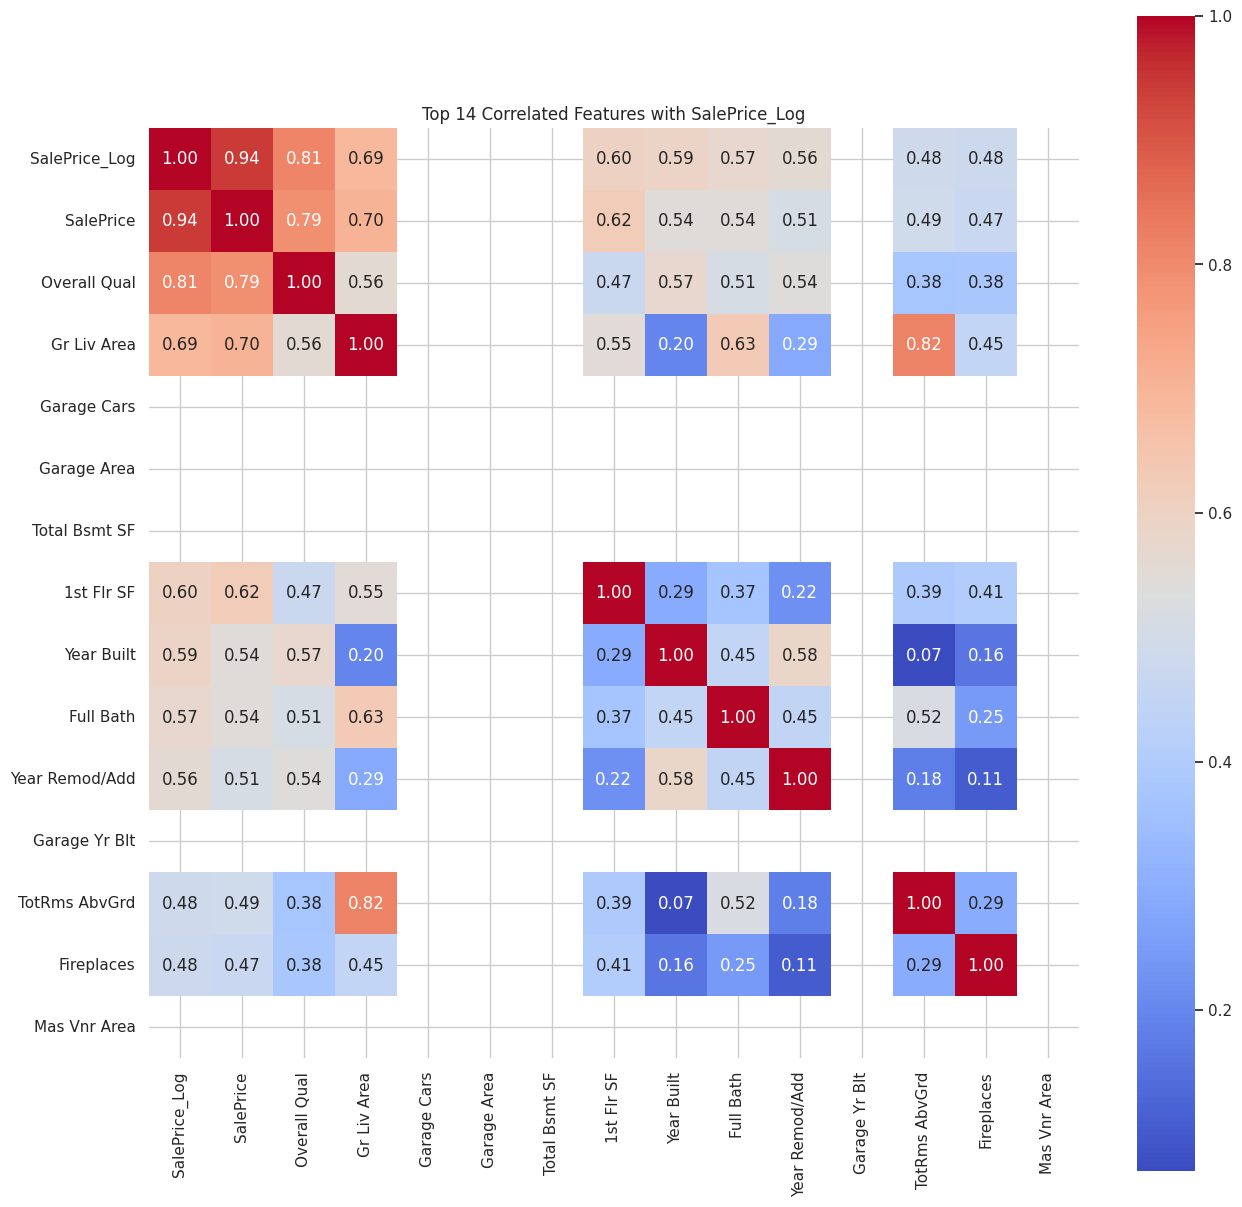

In [16]:

numeric_cols = df_train.select_dtypes(include=np.number).columns.tolist()
corrmat = df_train[numeric_cols].corr() # Use df_train as it now contains SalePrice_Log

# Find correlations with SalePrice_Log, sort them
k = 15 # Number of top correlations to show
cols = corrmat.nlargest(k, 'SalePrice_Log')['SalePrice_Log'].index
cm = np.corrcoef(df_train[cols].values.T)

plt.figure(figsize=(k, k))
sns.heatmap(cm, annot=True, square=True, fmt='.2f', cmap='coolwarm',
            yticklabels=cols.values, xticklabels=cols.values)
plt.title(f'Top {k-1} Correlated Features with SalePrice_Log')
plt.show()

# Insights: Features like 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF', '1stFlrSF' are highly positively correlated with SalePrice_Log.

## 2. Preprocessing

We need a robust preprocessing pipeline:
1.  Separate features (X) and target (y = `SalePrice_Log`).
2.  Handle missing values strategy:
    *   For features where NA means "None" (e.g., 'PoolQC', 'Alley', 'Fence', 'MiscFeature', Garage related where NA implies no garage, Bsmt related where NA implies no basement): Impute with 'None' (for categorical) or 0 (for numerical like 'GarageArea', 'BsmtFinSF1').
    *   For features where NA likely means truly missing data: Impute with median (for numerical) or mode (for categorical). ('LotFrontage' might benefit from group-wise median imputation, e.g., by Neighborhood).
    *   Drop features with extremely high missing percentage if they seem uninformative (optional, handle carefully).
3.  Transform skewed numerical features (using log1p like we did for SalePrice).
4.  Encode categorical features:
    *   Ordinal: For features with inherent order (e.g., quality ratings like 'Ex', 'Gd', 'TA', 'Fa', 'Po').
    *   Nominal (One-Hot): For features with no inherent order (e.g., 'Neighborhood', 'MSSubClass' if treated as categorical).
5.  Scale numerical features using `StandardScaler`.

In [17]:
df_train.columns = df_train.columns.str.replace(' ', '')

In [18]:
# Define target (using log-transformed price) and features
y = df_train['SalePrice_Log']
X = df_train.drop(['SalePrice', 'SalePrice_Log'], axis=1)

print(f"Shape of features X before preprocessing: {X.shape}")

# Identify numerical and categorical columns
numerical_cols = X.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X.select_dtypes(include='object').columns.tolist()

# Define features where NA means 'None' or 0
cat_na_means_none = ['Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 
                     'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageFinish', 
                     'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']
num_na_means_zero = ['GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 
                    'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea']

# Identify features needing mode/median imputation
cat_na_impute_mode = ['Electrical', 'MasVnrType', 'MSZoning', 'Functional', 
                      'Utilities', 'Exterior1st', 'Exterior2nd', 'KitchenQual', 'SaleType'] 
# Note: Check actual missing counts to confirm these are the ones left needing mode/median after filling NA='None'/0
# Example: 'LotFrontage' is numerical and often imputed by neighborhood median, more complex, let's use simple median for now.
num_na_impute_median = ['LotFrontage'] # Only one needing simple median after handling NA=0 cases

# Identify potentially ordinal features (example, adjust based on data dictionary)
# This requires careful reading of the data description!
ordinal_features_map = {
    'ExterQual': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'ExterCond': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'BsmtQual': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], # Added 'None' from imputation
    'BsmtCond': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], # Added 'None'
    'BsmtExposure': ['None', 'No', 'Mn', 'Av', 'Gd'], # Added 'None'
    'BsmtFinType1': ['None', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'], # Added 'None'
    'BsmtFinType2': ['None', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'], # Added 'None'
    'HeatingQC': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'KitchenQual': ['Fa', 'TA', 'Gd', 'Ex'], # Assuming Fa is worst here after imputation
    'FireplaceQu': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], # Added 'None'
    'GarageFinish': ['None', 'Unf', 'RFn', 'Fin'], # Added 'None'
    'GarageQual': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], # Added 'None'
    'GarageCond': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], # Added 'None'
    'PoolQC': ['None', 'Fa', 'TA', 'Gd', 'Ex'], # Added 'None'
    # Add other relevant ordinal features based on data dictionary, e.g. Utilities, Functional? LandSlope? PavedDrive?
    'Utilities': ['ELO', 'NoSeWa', 'NoSewr', 'AllPub'],
    'LandSlope': ['Sev', 'Mod', 'Gtl'],
    'PavedDrive': ['N', 'P', 'Y'],
}
ordinal_cols = list(ordinal_features_map.keys())
nominal_cols = [col for col in categorical_cols if col not in ordinal_cols]

# Log transform skewed numerical features (excluding discrete/year ones if desired)
# Threshold for skewness
skew_threshold = 0.75 
skewed_features = X[numerical_cols].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
high_skew = skewed_features[abs(skewed_features) > skew_threshold].index

# Exclude discrete or year features if log transform doesn't make sense
exclude_from_log = ['MSSubClass', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'MoSold', 'YrSold']
features_to_log = [feat for feat in high_skew if feat not in exclude_from_log]

print(f"\nNumerical features identified for log transformation: {features_to_log}")
for feat in features_to_log:
    X[feat] = np.log1p(X[feat]) # Apply log1p

# Create preprocessing pipelines
# Numerical features pipeline
# 1. Impute NA=0 where applicable
# 2. Impute remaining NA with median
# 3. Scale
num_pipeline = Pipeline([
    ('imputer_zero', SimpleImputer(strategy='constant', fill_value=0)), # For GarageYrBlt, etc., should be handled carefully, maybe mode? Using 0 here for simplicity.
    # Note: This needs to be applied selectively. Let's refine.
]) 
# It's easier to handle NA=0 and NA=median imputation BEFORE the pipeline using fillna, 
# then the pipeline just needs Median Imputation (if any remaining NAs) + Scaling.

# Fill NA based on meaning before pipeline
for col in cat_na_means_none:
    if col in X.columns: X[col] = X[col].fillna('None')
for col in num_na_means_zero:
    if col in X.columns: X[col] = X[col].fillna(0)
    
# Now impute remaining numerical NAs with median
for col in num_na_impute_median:
     if col in X.columns: X[col] = X[col].fillna(X[col].median())
        
# Now impute remaining categorical NAs with mode
for col in cat_na_impute_mode:
    if col in X.columns: X[col] = X[col].fillna(X[col].mode()[0])
    
# Verify no more NAs
print(f"\nRemaining NAs after manual imputation: {X.isnull().sum().sum()}") # Should be 0

# Now create pipelines for scaling and encoding (operating on pre-imputed data)
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

ordinal_transformer = Pipeline(steps=[
    # Pass categories explicitly to handle potential missing categories in train/test splits later
    ('ordinal', OrdinalEncoder(categories=[ordinal_features_map[col] for col in ordinal_cols], handle_unknown='use_encoded_value', unknown_value=-1)) # Handle unseen values
])

nominal_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)) # handle_unknown='ignore' drops unseen categories
])

# Create the ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('ord', ordinal_transformer, ordinal_cols),
        ('nom', nominal_transformer, nominal_cols)
    ],
    remainder='passthrough' # Keep any columns not specified (shouldn't be any if lists are correct)
)

Shape of features X before preprocessing: (1758, 81)

Numerical features identified for log transformation: ['PoolArea', 'MiscVal', 'LowQualFinSF', 'LotArea', '3SsnPorch', 'KitchenAbvGr', 'BsmtFinSF2', 'BsmtHalfBath', 'ScreenPorch', 'EnclosedPorch', 'OpenPorchSF', 'MasVnrArea', 'WoodDeckSF', 'LotFrontage', '1stFlrSF', 'GrLivArea', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', '2ndFlrSF', 'Fireplaces', 'TotRmsAbvGrd']

Remaining NAs after manual imputation: 0


In [19]:
# Apply preprocessing using pipeline
# We'll fit the preprocessor inside the modeling step or when splitting data
# Let's split the data first
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")

# Now fit the preprocessor on the training data and transform both sets
X_train_processed = preprocessor.fit_transform(X_train)
X_val_processed = preprocessor.transform(X_val)

# Get feature names after transformation (optional, but good for understanding)
try:
    # Correctly construct feature names after transformations
    num_features_out = numerical_cols
    ord_features_out = ordinal_cols
    # OneHotEncoder's get_feature_names_out needs input features list
    nom_features_out = preprocessor.named_transformers_['nom'].get_feature_names_out(nominal_cols).tolist()
    
    feature_names_out = num_features_out + ord_features_out + nom_features_out
    print(f"\nNumber of features after processing: {len(feature_names_out)}") 
    # print(feature_names_out) # Can be very long
except Exception as e:
    print(f"\nCould not retrieve feature names due to error: {e}")
    feature_names_out = None

print(f"Processed X_train shape: {X_train_processed.shape}")
print(f"Processed X_val shape: {X_val_processed.shape}")

# Convert processed arrays back to DataFrames (optional)
if feature_names_out is not None and len(feature_names_out) == X_train_processed.shape[1]:
     X_train_processed_df = pd.DataFrame(X_train_processed, columns=feature_names_out)
     X_val_processed_df = pd.DataFrame(X_val_processed, columns=feature_names_out)
     # print(X_train_processed_df.head())
else:
     print("\nCould not align processed data with feature names. Proceeding with NumPy arrays.")
     X_train_processed_df = X_train_processed # Keep as numpy array if names are problematic
     X_val_processed_df = X_val_processed

X_train shape: (1406, 81)
X_val shape: (352, 81)

Number of features after processing: 236
Processed X_train shape: (1406, 236)
Processed X_val shape: (352, 236)


## 🦮 Train and Evaluate Regression Models

### 🗻 Ridge regression

We will train and evaluate a Ridge regression model evaluating it with [RMSLE](https://www.datascienceland.com/blog/difference-between-rmse-and-rmsle-656/) metric (as per the [competition rules](www.kaggle.com/competitions/house-prices-iaac/overview/evaluation))

In [20]:
model = Ridge(alpha=10, random_state=42)

In [21]:
model.fit(X_train_processed_df, y_train) # Use DataFrame or NumPy array

Ridge(alpha=10, random_state=42)

In [22]:
y_pred_log_val = model.predict(X_val_processed_df) 

In [23]:
y_pred_log_val[:10]

array([12.12791295, 11.93673029, 12.01106581, 11.69777474, 12.21772254,
       12.70163841, 12.15008436, 11.69854475, 12.33047038, 12.11648905])

In [24]:
rmse_log = np.sqrt(mean_squared_error(y_val, y_pred_log_val))
rmse_log

np.float64(0.13134328452138028)

#### Hyperparameters

This model (as almost any other) has a set of parameters that impact its performance. Let's try different ones and see which ones work best for our data.

In [25]:
alphas = range(10)
solvers = ['auto', 'svd']  # 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'

for a in alphas:
    for s in solvers:
        model = Ridge(alpha=a, solver=s)
        model.fit(X_train_processed, y_train)
        y_pred = model.predict(X_val_processed)
        err = np.sqrt(mean_squared_error(y_val, y_pred))
        print(f"Ridge Model (alpha={a}, solver={s}) - RMSLE: {err:.4f}")

Ridge Model (alpha=0, solver=auto) - RMSLE: 166745621622.2792
Ridge Model (alpha=0, solver=svd) - RMSLE: 166745621622.2792
Ridge Model (alpha=1, solver=auto) - RMSLE: 0.1320
Ridge Model (alpha=1, solver=svd) - RMSLE: 0.1320
Ridge Model (alpha=2, solver=auto) - RMSLE: 0.1317
Ridge Model (alpha=2, solver=svd) - RMSLE: 0.1317
Ridge Model (alpha=3, solver=auto) - RMSLE: 0.1315
Ridge Model (alpha=3, solver=svd) - RMSLE: 0.1315
Ridge Model (alpha=4, solver=auto) - RMSLE: 0.1314
Ridge Model (alpha=4, solver=svd) - RMSLE: 0.1314
Ridge Model (alpha=5, solver=auto) - RMSLE: 0.1313
Ridge Model (alpha=5, solver=svd) - RMSLE: 0.1313
Ridge Model (alpha=6, solver=auto) - RMSLE: 0.1313
Ridge Model (alpha=6, solver=svd) - RMSLE: 0.1313
Ridge Model (alpha=7, solver=auto) - RMSLE: 0.1313
Ridge Model (alpha=7, solver=svd) - RMSLE: 0.1313
Ridge Model (alpha=8, solver=auto) - RMSLE: 0.1313
Ridge Model (alpha=8, solver=svd) - RMSLE: 0.1313
Ridge Model (alpha=9, solver=auto) - RMSLE: 0.1313
Ridge Model (alpha

### 🌲🌳 RandomForest

In [26]:
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, max_depth=15, min_samples_split=5, min_samples_leaf=3)

In [27]:
model.fit(X_train_processed_df, y_train) 
y_pred_log_val = model.predict(X_val_processed_df) 
rmse_log = np.sqrt(mean_squared_error(y_val, y_pred_log_val))
rmse_log

np.float64(0.15637001974935652)

How would this model work with a different amount of trees (estimators)? or a different tree depth?

## 🧩 Try other models

Try other models with different hyperparameters and evaluate them against Ridge. Some examples include but are not limited to:

```py
RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, max_depth=15, min_samples_split=5, min_samples_leaf=3)
GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42) 
XGBRegressor(
    n_estimators=1000,  # Number of trees
    learning_rate=0.05,  # Step size shrinkage
    max_depth=6,  # Maximum depth of a tree
    subsample=0.8,  # Subsample ratio of the training instances
    colsample_bytree=0.8,  # Subsample ratio of columns when constructing each tree
    random_state=42
)
lgbm_model = LGBMRegressor(
    n_estimators=1000,  # Number of boosting iterations
    learning_rate=0.05,  # Learning rate
    max_depth=6,  # Maximum depth of a tree
    subsample=0.8,  # Subsample ratio of the training instances
    colsample_bytree=0.8,  # Subsample ratio of columns when constructing each tree
    random_state=42
)
```

**❕Make sure you import all the necessary packages!**

## 🎢 Make predictions

Read the test file and **make sure you preprocess it in the same way** as the train set

In [29]:
df_test = pd.read_csv('/home/salvador_cb/3_term/AECinCode_tutorials/house-prices-iaac/test.csv')
df_test.columns = df_test.columns.str.replace(' ', '')
df_test.drop('Id', axis=1, inplace=True)
X_test_p = preprocessor.fit_transform(df_test)

In [30]:
y_test = model.predict(X_test_p) 

## 📦 Submit your results

In [32]:
sample_submission = pd.read_csv('/home/salvador_cb/3_term/AECinCode_tutorials/house-prices-iaac/sample_submission.csv')

In [33]:
def generate_submission(predictions, output_file):
    if len(predictions) != len(sample_submission):
        raise ValueError("The length of predictions {} must match the sample_submission DataFrame {}.".format(len(predictions), len(sample_submission)))
    # Ensure predictions are in the correct format
    sample_submission['SalePrice'] = predictions
    sample_submission.to_csv(output_file, index=False)

In [36]:
generate_submission(y_test, "{}/submission.csv".format("/home/salvador_cb/3_term/AECinCode_tutorials/house-prices-iaac"))

🥳🥳 Now you are ready to submit!

<div display="flex" flex-direction="row"><img src="../.assets/kaggle/submit.jpg" width=45% padding=5px/><img src="../.assets/kaggle/submitted.jpg" width=45% padding=5px/></div>